In [227]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from scipy.signal import savgol_filter
import pywt
# from PyEMD import EMD
from scipy.fftpack import fft, ifft, fftshift
from joblib import Parallel, delayed

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
# from one_functions_generic import prepro
from design_functions import wheel_velocity
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [2]:
bin_size = 0.1
multiplier = 1/bin_size

response_threshold = 0.3 # radians
velocity_threshold = 100 # degrees/s
monotonic_threshold = -.0005  # TODO: should validate more methodically

## Get data

In [3]:
# Load preprocessed data
results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'
results_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'

os.chdir(results_path)
states_trial_type = pickle.load(open("states_trial_type.pkl", "rb"))

Example session

In [4]:
eids = np.unique(states_trial_type['session'])
mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids[0:1]):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)

## Morlet wavelet transform 
- Code adapted from MATLAB to python by chatgpt
- Paper: https://link.springer.com/article/10.1186/s13229-022-00492-8

In [5]:

def morlet_conj_ft(omega_vals, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    return np.pi**(-1/4) * np.exp(-0.5 * (omega_vals - omega0)**2)

def fast_wavelet_morlet_convolution_parallel(x, f, omega0, dt):
    """
    Fast Morlet wavelet transform using parallel computation.

    Args:
        x (array): 1D array of projection values to transform.
        f (array): Center frequencies of the wavelet frequency channels (Hz).
        omega0 (float): Dimensionless Morlet wavelet parameter.
        dt (float): Sampling time (seconds).

    Returns:
        amp (array): Wavelet amplitudes.
        W (array): Wavelet coefficients (complex-valued, optional).
    """
    N = len(x)
    L = len(f)
    amp = np.zeros((L, N))
    Q = np.zeros((L, N))

    # Ensure N is even
    if N % 2 == 1:
        x = np.append(x, 0)
        N += 1
        test = True
    else:
        test = False

    # Add zero padding to x
    # Zero padding serves to compensate for the fact that the kernel does not have the same size as 
    # 
    x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
    M = N
    N = len(x)

    # Compute scales
    scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
    omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)

    # Fourier transform of x
    x_hat = fftshift(fft(x))

    # Index for truncation to recover the actual x without padding
    if test:
        idx = np.arange(M // 2, M // 2 + M - 1)
    else:
        idx = np.arange(M // 2, M // 2 + M)

    # Function for parallel processing
    def process_frequency(i):
        m = morlet_conj_ft(-omega_vals * scales[i], omega0)
        # Convolution on the Fourier domain (as opposed to time domain in DWT)
        conv = m * x_hat
        # Inverse Fourier transform (normalized?)
        q = ifft(conv) * np.sqrt(scales[i])
        q = q[idx]
        amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])
        return amp_row, q

    # Parallel processing
    results = Parallel(n_jobs=-1)(delayed(process_frequency)(i) for i in range(L))

    for i, (amp_row, q) in enumerate(results):
        amp[i, :] = amp_row
        Q[i, :] = q

    return amp, Q, x_hat

In [6]:
x = np.diff(pos[:10000])
dt = 0.001
f = np.array([0.25, .5, 1, 2, 4, 8, 16])
omega0 = 5

N = len(x)
L = len(f)
amp = np.zeros((L, N))
Q = np.zeros((L, N))

# Ensure N is even
if N % 2 == 1:
    x = np.append(x, 0)
    N += 1
    test = True
else:
    test = False

# Add zero padding to x
# Zero padding serves to compensate for the fact that the kernel does not have the same size as 
# 
x = np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))
M = N
N = len(x)

# Compute scales
scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)

# Fourier transform of x
x_hat = fftshift(fft(x))

# Index for truncation
if test:
    idx = np.arange(M // 2, M // 2 + M - 1)
else:
    idx = np.arange(M // 2, M // 2 + M)


i = 0
m = morlet_conj_ft(-omega_vals * scales[i], omega0)
# Convolution on the Fourier domain (as opposed to time domain in DWT)
conv = m * x_hat
# Inverse Fourier transform (normalized?)
q = ifft(conv) * np.sqrt(scales[i])
q = q[idx]
amp_row = np.abs(q) * np.pi**-0.25 * np.exp(0.25 * (omega0 - np.sqrt(omega0**2 + 2))**2) / np.sqrt(2 * scales[i])




/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_352661/3469913169.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


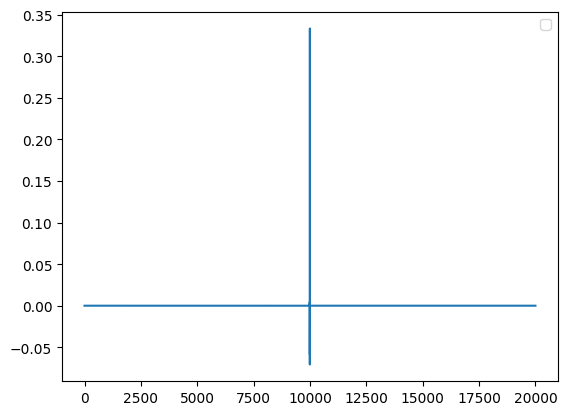

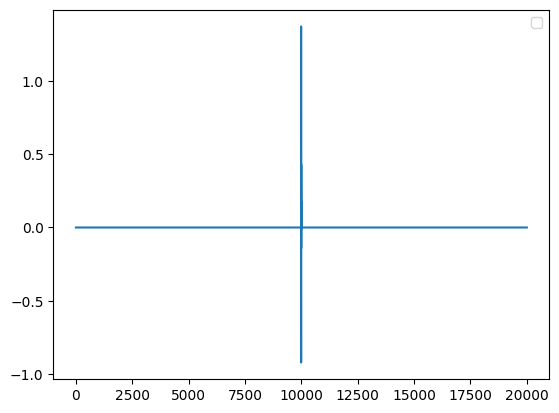

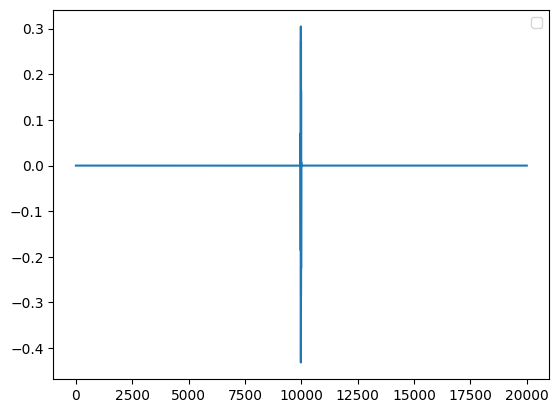

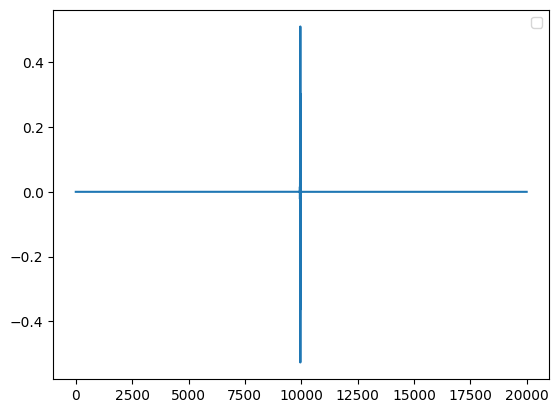

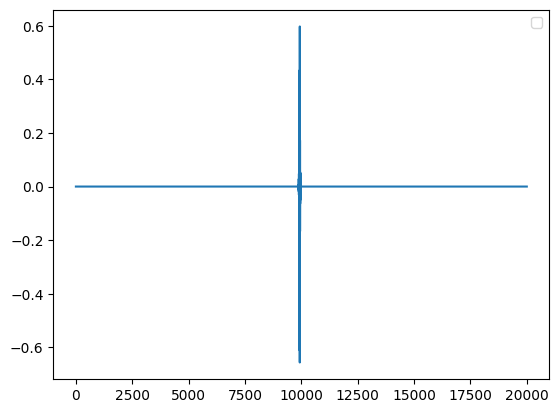

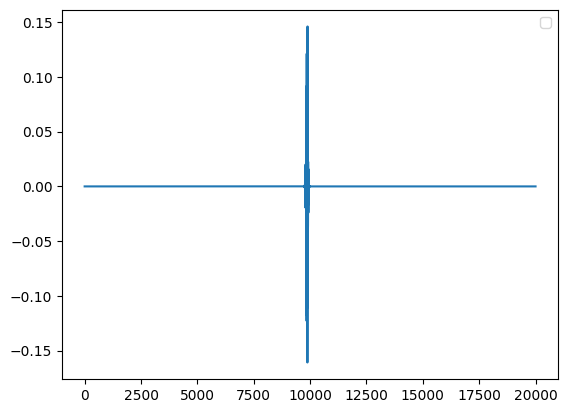

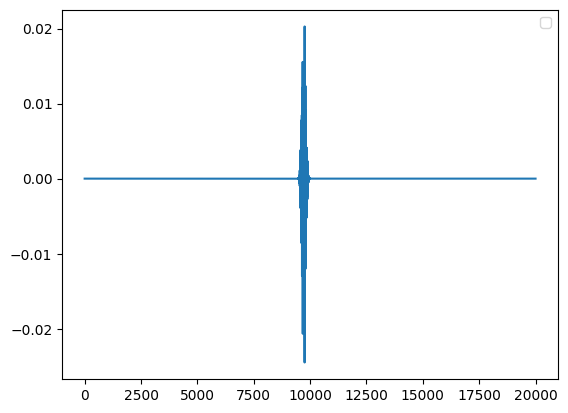

In [8]:
for i, ii in enumerate(f):
    m = morlet_conj_ft(-omega_vals * scales[i], omega0)
    # plt.plot(x_hat, alpha=.5)
    # plt.plot(m)
    conv = m * x_hat
    plt.plot(conv)
    # plt.plot(ifft(conv))
    plt.legend()
    # plt.xlim([9800, 10050])
    # plt.ylim([-2, 2])
    plt.show()

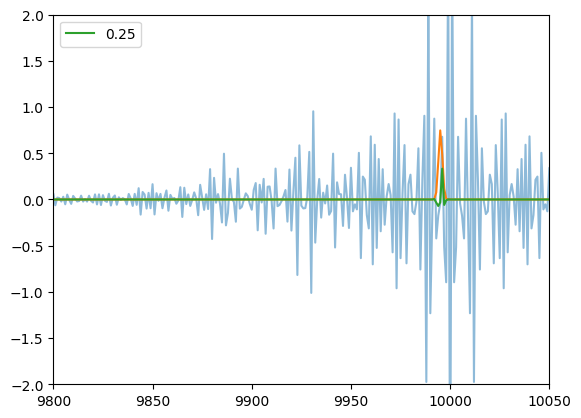

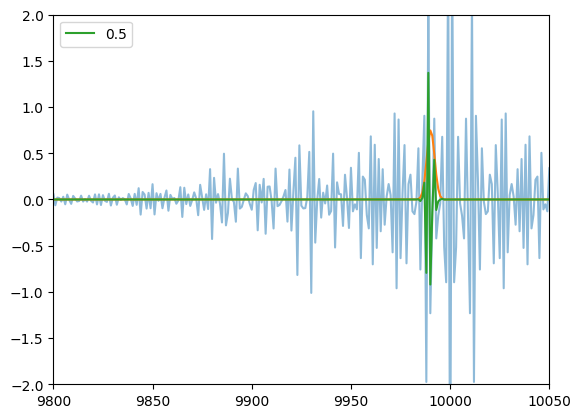

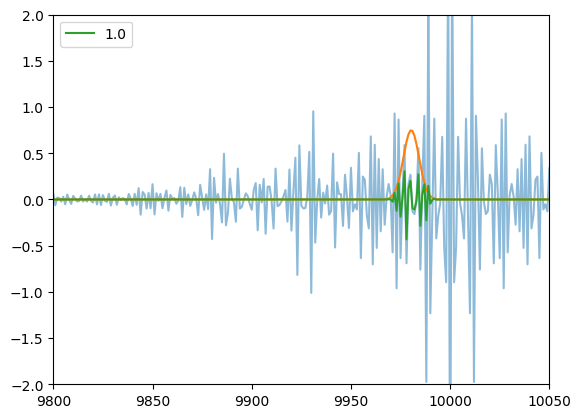

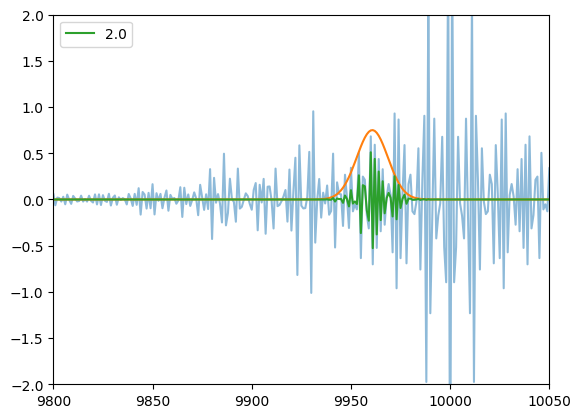

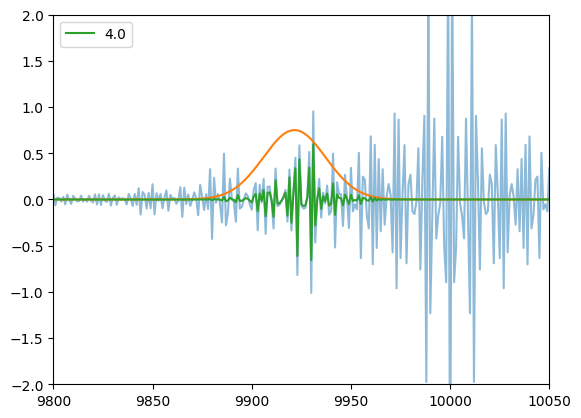

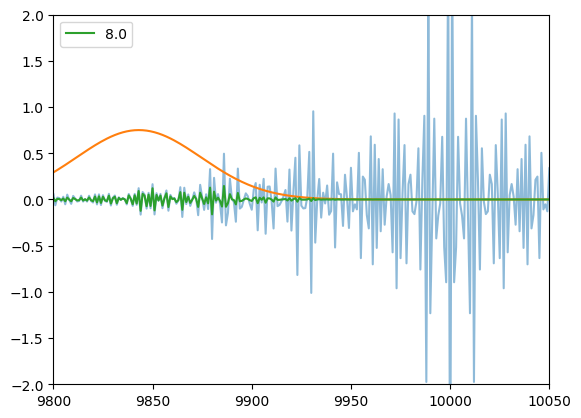

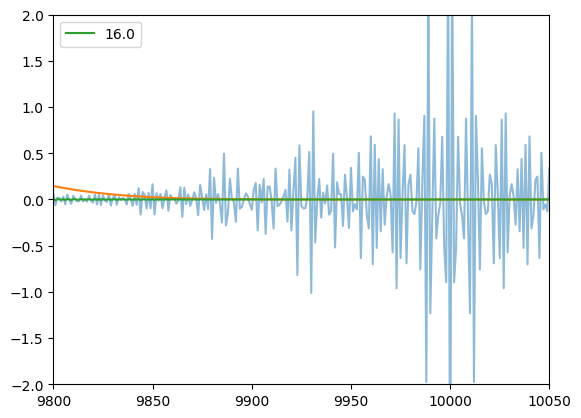

In [9]:

for i, ii in enumerate(f):
    m = morlet_conj_ft(-omega_vals * scales[i], omega0)
    plt.plot(x_hat, alpha=.5)
    plt.plot(m)
    conv = m * x_hat
    plt.plot(conv, label=str(ii))
    plt.legend()
    plt.xlim([9800, 10050])
    plt.ylim([-2, 2])
    plt.show()

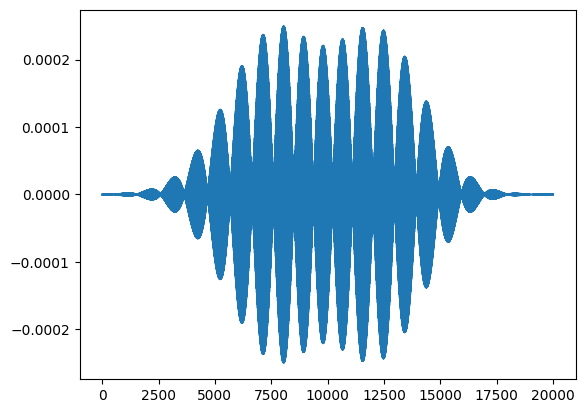

In [54]:
plt.plot(ifft(conv) * np.sqrt(scales[i]))

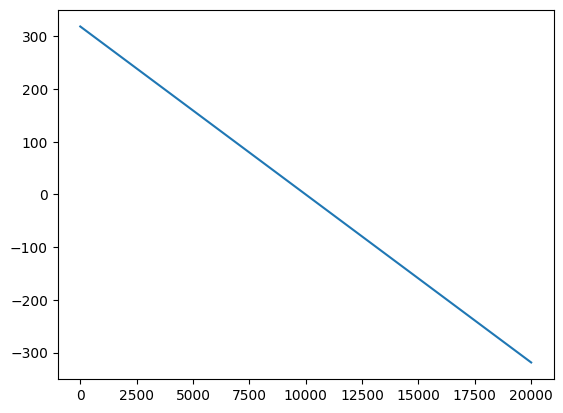

In [44]:
plt.plot(-omega_vals * scales[5])

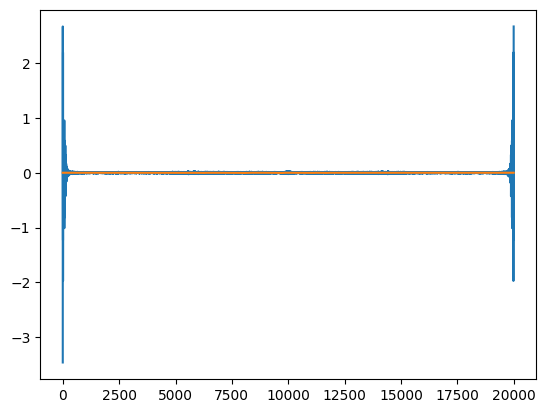

In [33]:
plt.plot(fft(x))
plt.plot(x)
# plt.plot(fft(x))
# plt.ylim([-.5, .5])

## Morlet wavelet

<Figure size 1000x600 with 0 Axes>

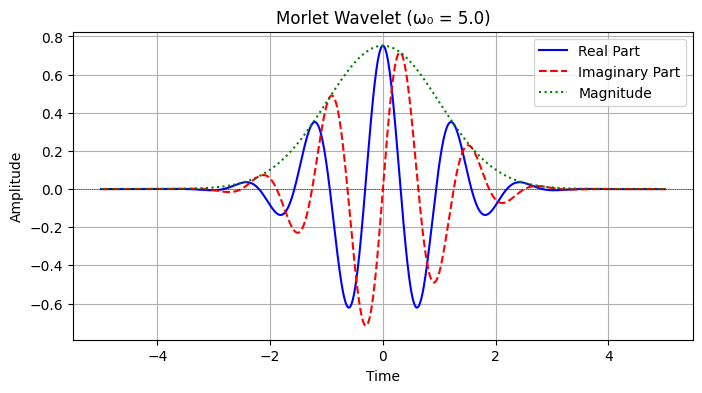

In [7]:
def morlet_wavelet(t, omega0):
    """
    Compute the Morlet wavelet in the time domain.

    Parameters:
    - t: Time values (array-like)
    - omega0: Central frequency of the wavelet

    Returns:
    - wavelet: Complex-valued Morlet wavelet
    """
    # Morlet wavelet formula: π^(-1/4) * exp(i * omega0 * t) * exp(-t^2 / 2)
    normalization = np.pi**(-1/4)
    carrier = np.exp(1j * omega0 * t)  # Oscillatory component
    envelope = np.exp(-t**2 / 2)       # Gaussian envelope
    return normalization * carrier * envelope
    # return carrier * envelope

# Parameters
omega0 = 5.0   # Central frequency of the wavelet
t = np.linspace(-5, 5, 1000)  # Time values

# Compute the Morlet wavelet
wavelet = morlet_wavelet(t, omega0)

# Plot the wavelet
plt.figure(figsize=(10, 6))
plt.figure(figsize=(8, 4))

# Plot the real part
plt.plot(t, wavelet.real, label='Real Part', color='blue')

# Plot the imaginary part
plt.plot(t, wavelet.imag, label='Imaginary Part', color='red', linestyle='dashed')

# Plot the magnitude (envelope)
plt.plot(t, np.abs(wavelet), label='Magnitude', color='green', linestyle='dotted')

# Add labels, legend, and title
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Morlet Wavelet (ω₀ = {omega0})")
plt.axhline(0, color='black', linewidth=0.5, linestyle='dotted')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Omega vals
- omega_vals corresponds to the angular frequencies of the Fourier transform
- The Fourier transform converts a signal form the time domain (length N) to the frequency domain, producing N equally spaced frequency bins
- the number of bins (or points) in the frequency domain must match the number of points in the time domain of the discrete Fourier transform
- for a signal of length N, the frequency resolution is determined by N because the ranfe of discrete frequencies is divided into N bins; it is scaled 2pi to have frequency in radians/second

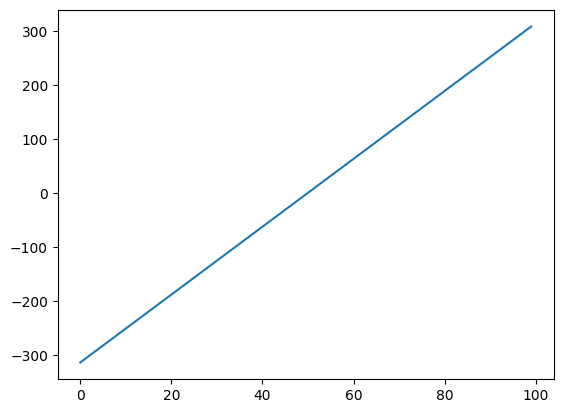

In [10]:
N = 100
dt = 0.01
omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)
plt.plot(omega_vals)

## Padding
- Adds zeros to the left and right of the signal in an amount that equals half the length of the kernel (N)

In [11]:
x = np.diff(pos[:10000])
N = len(x)
# Ensure N is even
if N % 2 == 1:
    x = np.append(x, 0)
    N += 1
    test = True
else:
    test = False
np.concatenate((np.zeros(N // 2), x, np.zeros(N // 2)))

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
len(np.zeros(N // 2))

5000

In [117]:
np.arange(-N // 2, N // 2) / (N * dt)

array([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40.,
       -39., -38., -37., -36., -35., -34., -33., -32., -31., -30., -29.,
       -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.])

In [17]:
f = np.array([0.25, .5, 1, 2, 4])
scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
scales

array([3.24553612, 1.62276806, 0.81138403, 0.40569201, 0.20284601])

## Morlet conjugate 


[1.62442291e-01 2.43854761e-01 4.55580672e-01 7.51125544e-01
 1.01653788e-01 1.14396268e-08 2.06468264e-43]


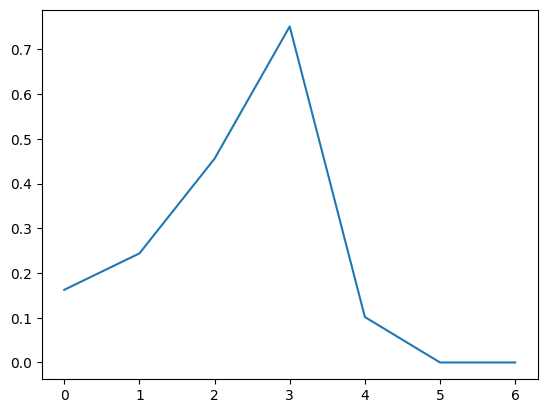

In [11]:

w = np.array([.25, .5, 1, 2, 4, 8, 16])
omega0 = 2
def morlet_conj_ft(w, omega0):
    """
    Computes the conjugate Fourier transform of the Morlet wavelet.
    
    Parameters:
    - w: Angular frequency values (array or scalar)
    - omega0: Dimensionless Morlet wavelet parameter
    
    Returns:
    - out: Conjugate Fourier transform of the Morlet wavelet
    """
    return np.pi**(-1/4) * np.exp(-0.5 * (w - omega0)**2)

conj = morlet_conj_ft(w, omega0)
print(conj)
plt.plot(conj)

In [12]:

y = np.diff(pos[:10000])
dt = 0.001
N = len(y)
f = np.array([0.25, .5, 1, 2, 4, 8, 16])
scales = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * f)
omega_vals = 2 * np.pi * np.arange(-N // 2, N // 2) / (N * dt)
i = 1
m = morlet_conj_ft(-omega_vals * scales[i], omega0)


Text(0.5, 1.0, 'Conjugate Fourier transform of scaled Morlets')

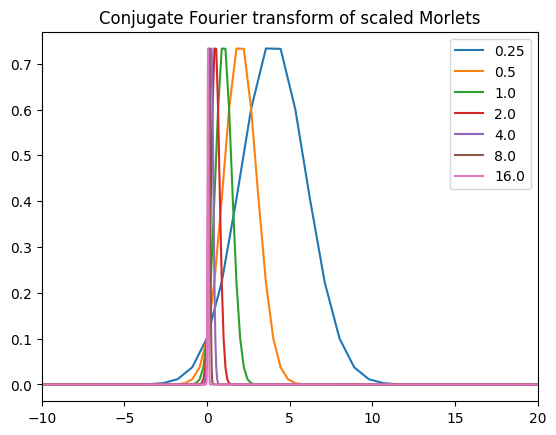

In [13]:
for i, ii in enumerate(f):
    
    plt.plot(-omega_vals * scales[i], m, label=str(ii))
    plt.xlim([-10, 20])
    plt.legend()
plt.title('Conjugate Fourier transform of scaled Morlets')

## Test with real data

In [8]:
eids = np.unique(states_trial_type['session'])
mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids[0:1]):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(9500.0, 10500.0)

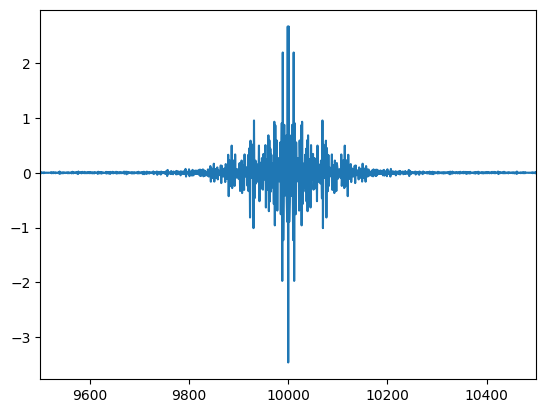

In [9]:
plt.plot(x_hat)
plt.xlim([9500, 10500])

/tmp/ipykernel_385415/3685349517.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q


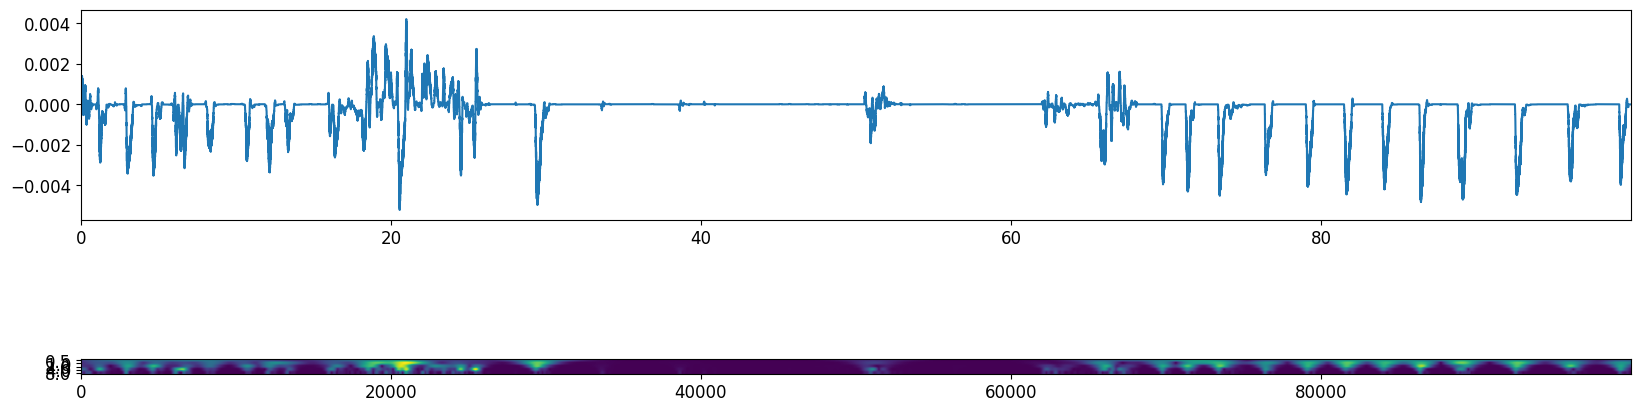

In [69]:
y = np.diff(pos[0000:100000])
dt = 0.001
x = np.arange(0, len(y)) * dt

fig, ax = plt.subplots(ncols=1 , nrows=2, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)

# Plot raw trace
ax[0].plot(x, y)
ax[0].set_xlim([0, np.max(x)])

f = np.array([.25, .5, 1, 2, 4, 8, 16])
f = np.array([.5, 1, 2, 4, 8])
omega0 = 5

amp, q, x_hat = fast_wavelet_morlet_convolution_parallel(y, f, omega0, dt)

ax[1].imshow(amp, aspect='200')

ax[1].set_yticks(np.arange(0, len(f)), f)
# ax[2].set_xticksnp.arange(0, len(y)), np.arange(0, len(y)) * df)


In [230]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import GaussianMixtureHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs, cross_validate_model
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)

from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
from plotting_functions import plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates

one = ONE(mode='remote')

In [70]:
y = np.diff(pos)
dt = 0.001
x = np.arange(0, len(y)) * dt

f = np.array([.25, .5, 1, 2, 4, 8, 16])
f = np.array([.5, 1, 2, 4, 8])
omega0 = 5

amp, q, x_hat = fast_wavelet_morlet_convolution_parallel(y, f, omega0, dt)


/tmp/ipykernel_385415/3685349517.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q


In [297]:
use_data = amp.T
# use_data = y
num_train_batches = 5
num_lags = 2
num_states = 6
method = 'kmeans'
threshold = 1000000
kappa = 1000
donwsampling_factor = 100

In [281]:
var = use_data[:threshold,:]
downsampled_signal = var[::donwsampling_factor]
# var = use_data[:threshold]
scaler = StandardScaler()
standardized = scaler.fit_transform(downsampled_signal)
# Normalize between 0 and 1
normalizer = Normalizer()
normalized = normalizer.fit_transform(standardized)

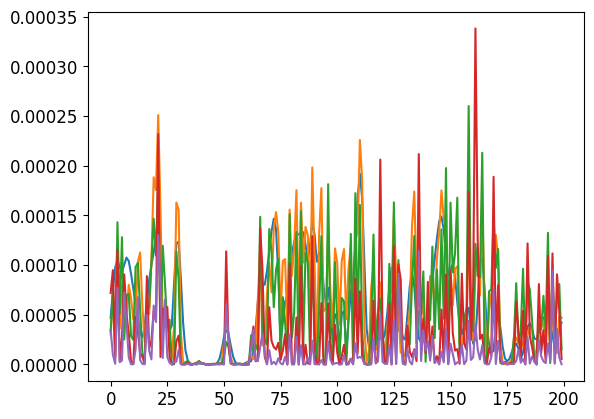

In [209]:
plt.plot(downsampled_signal[:200])

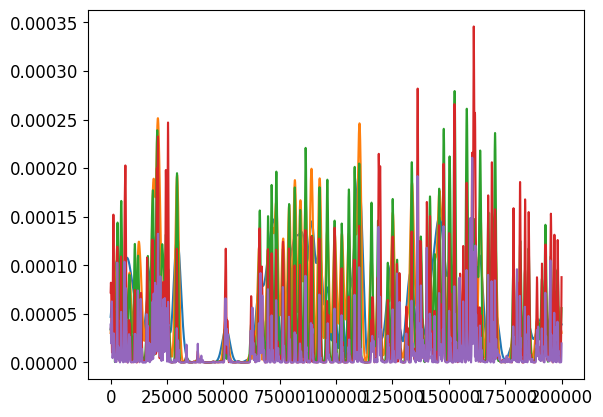

In [210]:
plt.plot(var[:200000])

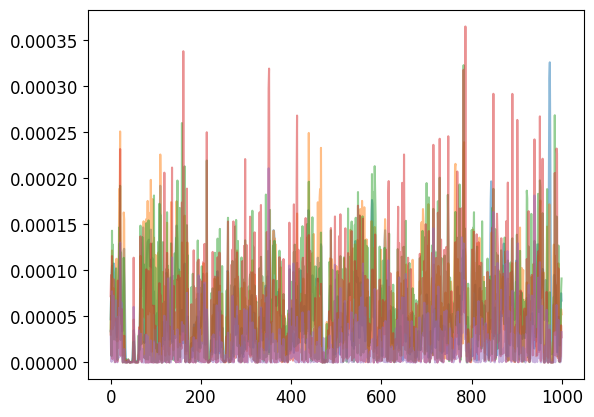

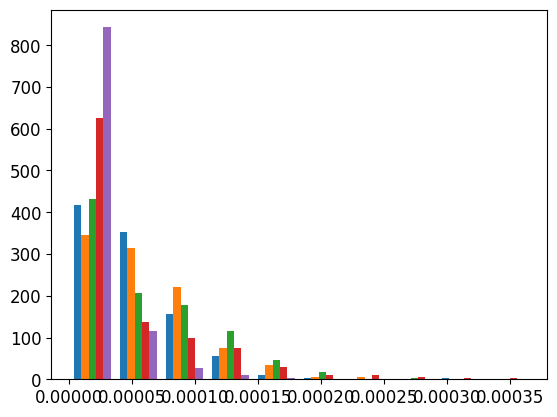

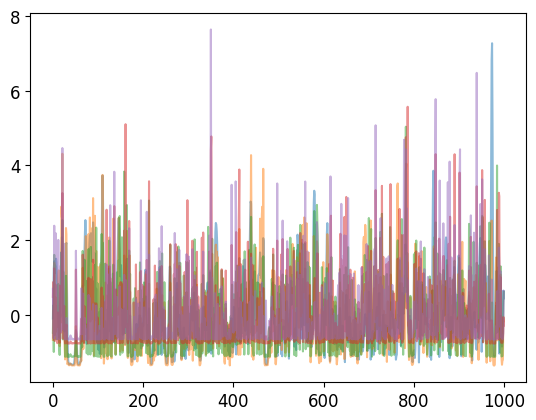

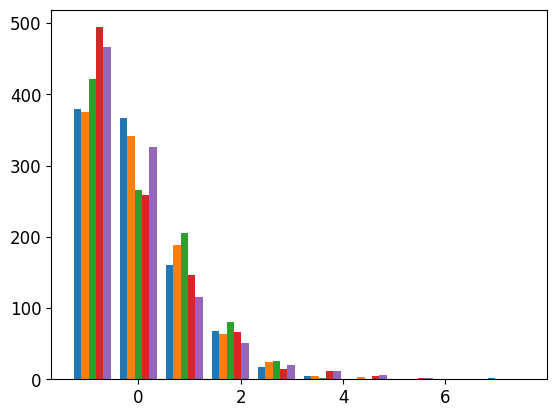

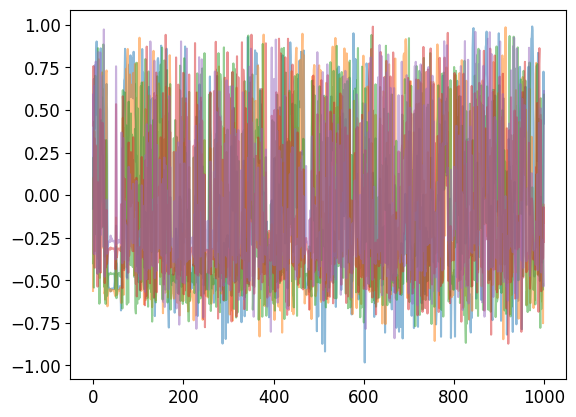

(array([[ 16.,  60., 219., 157., 149., 110.,  85.,  88.,  78.,  38.],
        [  4.,  99., 224., 124., 118., 108., 121.,  82.,  91.,  29.],
        [  1., 127., 256.,  96.,  88.,  82., 121., 109.,  95.,  25.],
        [  3.,  43., 253., 271.,  94.,  63.,  92.,  95.,  59.,  27.],
        [  2.,  32., 168., 376., 126.,  81.,  69.,  65.,  50.,  31.]]),
 array([-0.98356685, -0.78613587, -0.58870488, -0.39127389, -0.1938429 ,
         0.00358809,  0.20101908,  0.39845006,  0.59588105,  0.79331204,
         0.99074303]),
 <a list of 5 BarContainer objects>)

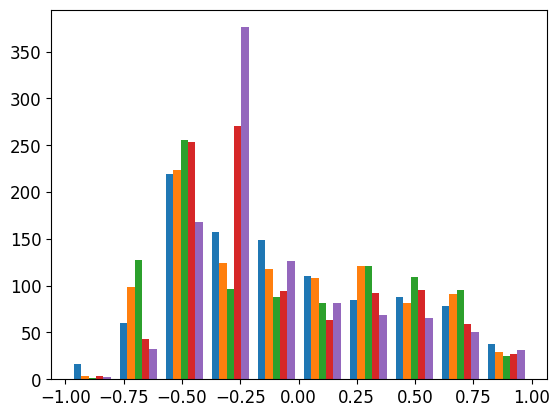

In [211]:
plt.plot(downsampled_signal, alpha=0.5)
plt.show()
plt.hist(downsampled_signal)
plt.show()
plt.plot(standardized, alpha=.5)
plt.show()
plt.hist(standardized)
plt.show()
plt.plot(normalized, alpha=.5)
plt.show()
plt.hist(normalized)



In [298]:

# Prepare data format
design_matrix = standardized.copy()
num_timesteps = np.shape(design_matrix)[0]
emission_dim = np.shape(design_matrix)[1]
shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches, :])
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    
test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa)  # , transition_matrix_stickiness=kappa
# Compute inputs for required timelags
my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                    train_emissions, train_inputs, method, num_train_batches)

use_fold = np.where(all_val_lls==np.nanmax(all_val_lls))[0][0]
# Find parameters for best fold
initial_probs = fit_params[0].probs[use_fold]
transition_matrix = fit_params[1].transition_matrix[use_fold]
emission_weights = fit_params[2].weights[use_fold]
emission_biases = fit_params[2].biases[use_fold]
emission_covariances = fit_params[2].covs[use_fold]        
    
# Initialize new hmm
new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=kappa) # , transition_matrix_stickiness=kappa
best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                initial_probs=initial_probs,
                                transition_matrix=transition_matrix,               
                                emission_weights=emission_weights,
                                emission_biases=emission_biases, 
                                emission_covariances=emission_covariances,
                                emissions=shortened_array)  # not sure if I need to include  

# Get state estimates for validation data
ar_most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)


        

(0.0, 400.0)

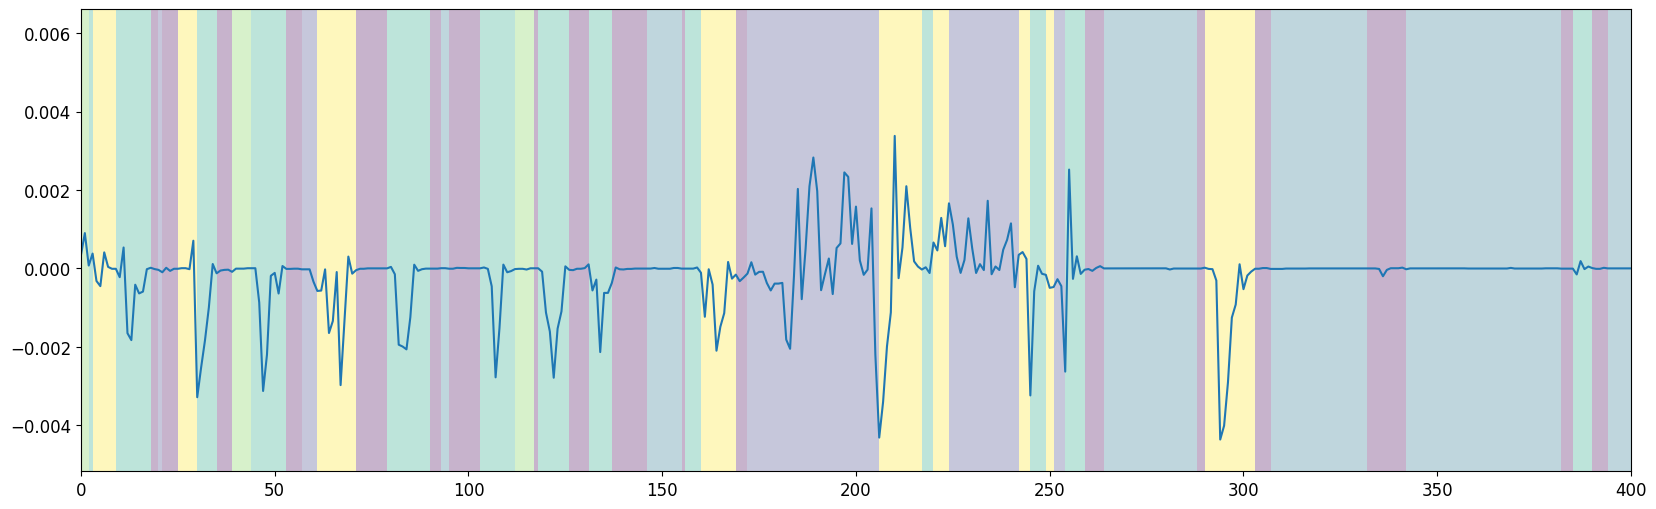

In [307]:
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)
# Plot raw trace


y_use = y[:threshold]
downsampled_y = y_use[::donwsampling_factor]
ax.plot(downsampled_y)
ax.imshow(np.concatenate([ar_most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([ar_most_likely_states])), np.min(downsampled_y), np.max(downsampled_y)),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
ax.set_xlim([0, 400])

(0.0, 400.0)

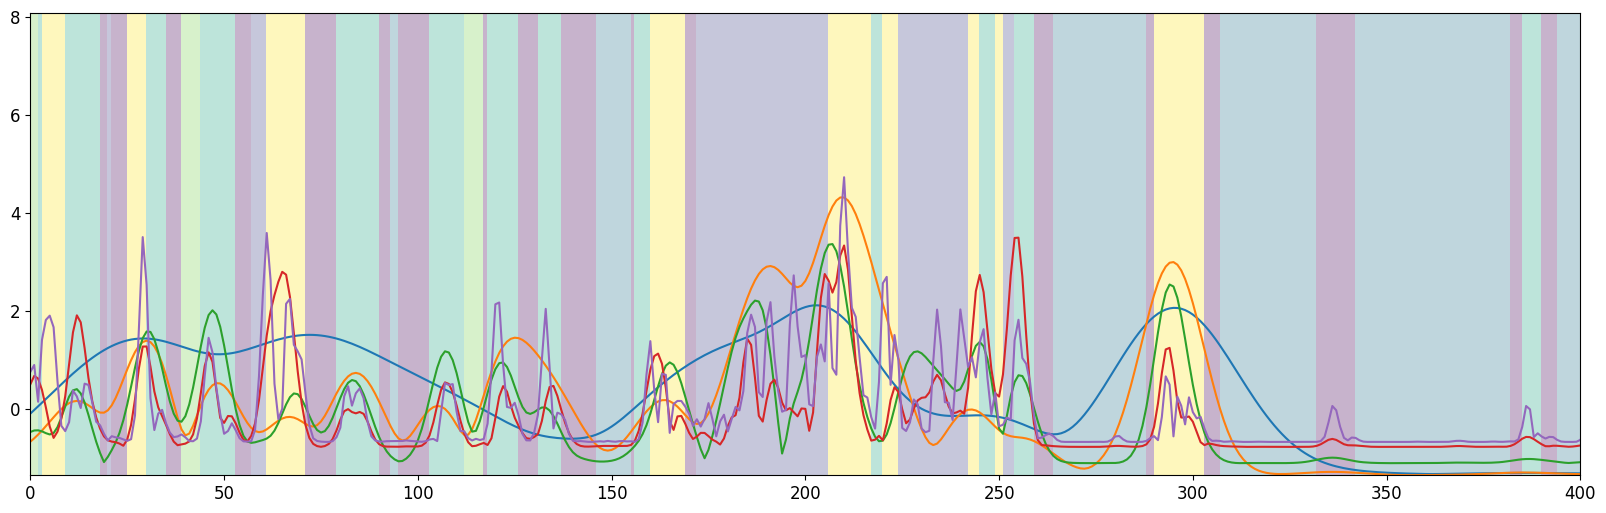

In [308]:
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)
# Plot raw trace
ax.plot(standardized)

ax.imshow(np.concatenate([ar_most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([ar_most_likely_states])), np.min(standardized), np.max(standardized)),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
ax.set_xlim([0, 400])

### GMM-HMM

In [292]:
num_components = 2
method='kmeans'

In [299]:

# Prepare data format
design_matrix = standardized.copy()
num_timesteps = np.shape(design_matrix)[0]
emission_dim = np.shape(design_matrix)[1]
shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches, :])
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    
test_gmmhmm = GaussianMixtureHMM(num_states, num_components, emission_dim, transition_matrix_stickiness=kappa)  # , transition_matrix_stickiness=kappa

al_lls, fit_params, init_params, baseline_val_lls, ll_train = cross_validate_model(test_gmmhmm, jr.PRNGKey(0), shortened_array, 
                                    train_emissions, method, num_train_batches)

use_fold = np.where(al_lls==np.nanmax(al_lls))[0][0]

# Find parameters for best fold
initial_probs = fit_params[0].probs[use_fold]
transition_matrix = fit_params[1].transition_matrix[use_fold]
emission_weights = fit_params[2].weights[use_fold]
emission_means = fit_params[2].means[use_fold]
emission_covariances = fit_params[2].covs[use_fold]        
    
# Initialize new hmm
new_gmmhmm = GaussianMixtureHMM(num_states, num_components, emission_dim, transition_matrix_stickiness=kappa) # , transition_matrix_stickiness=kappa
best_fold_params, props = new_gmmhmm.initialize(key=jr.PRNGKey(0), method=method,
                                initial_probs=initial_probs,
                                transition_matrix=transition_matrix,               
                                emission_weights=emission_weights,
                                emission_means=emission_means, 
                                emission_covariances=emission_covariances,
                                emissions=shortened_array)  # not sure if I need to include  

# Get state estimates for validation data
gmm_most_likely_states = new_gmmhmm.most_likely_states(best_fold_params, shortened_array)

(0.0, 400.0)

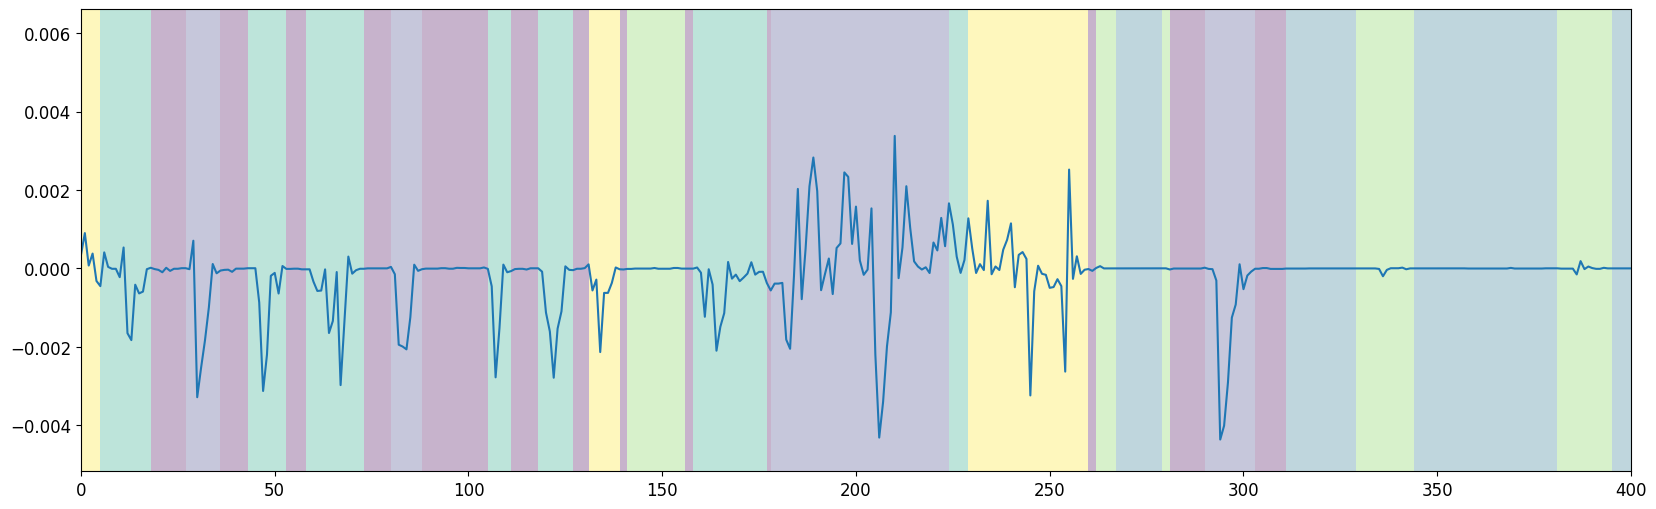

In [300]:
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)
# Plot raw trace


y_use = y[:threshold]
downsampled_y = y_use[::donwsampling_factor]
ax.plot(downsampled_y)
ax.imshow(np.concatenate([gmm_most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([gmm_most_likely_states])), np.min(downsampled_y), np.max(downsampled_y)),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
ax.set_xlim([0, 400])

(0.0, 400.0)

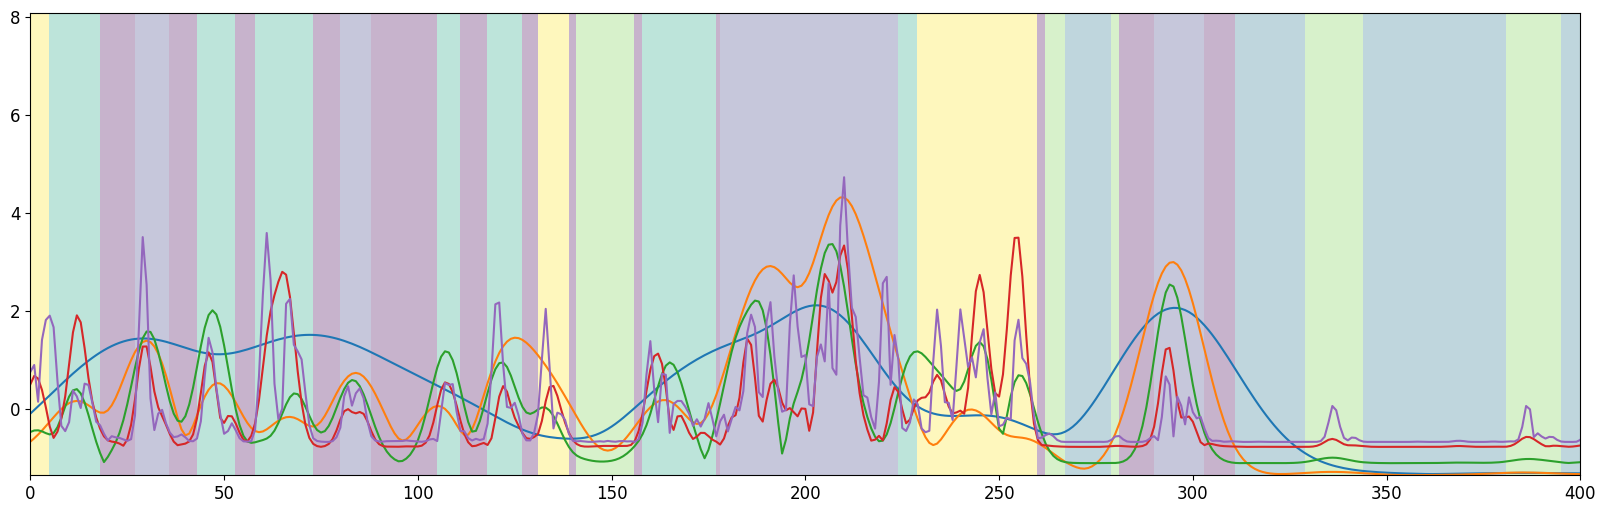

In [304]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
plt.rc('font', size=12)
# Plot raw trace
ax.plot(standardized)

ax.imshow(np.concatenate([gmm_most_likely_states])[None,:], 
            extent=(0, len(np.concatenate([gmm_most_likely_states])), np.min(standardized), np.max(standardized)),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 
ax.set_xlim([0, 400])


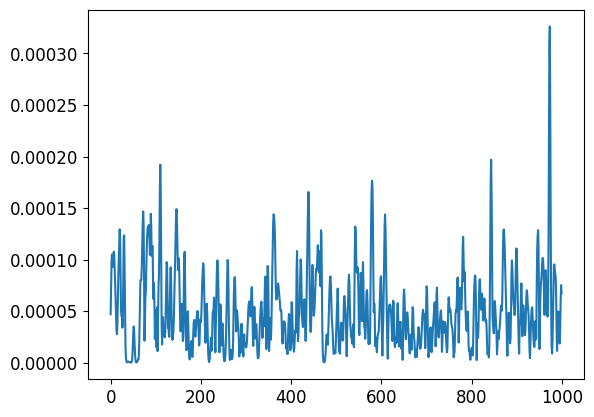

In [197]:
plt.plot(downsampled_signal)

In [15]:
def DWT(data):
    # Use the Daubechies wavelet

    w = pywt.Wavelet('db2')
    # Perform Wavelet transform up to log2(N) levels
    N = len(data)
    lvls = 10
    cA5, cD10, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1  = pywt.wavedec(data, w, mode='constant', level=lvls)
    cDs = cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10

    # Determine the length of the last row
    target_length = len(cDs[0])
    # Initialize the new array
    aligned_array = []
    all_levels = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

    for l, level in enumerate(range(lvls)):
        coeff = cDs[l]
        new_row = np.zeros(target_length)  # Create a new row of zeros
        num_elements = len(coeff)
        
        # Fill the new row according to the level
        for e in range(num_elements):
            
            length_elements = round(target_length // num_elements)
            
            start_idx = e * length_elements
            end_idx = start_idx + length_elements - 1
            
            if e < num_elements:
                new_row[start_idx:end_idx] = coeff[e]

        aligned_array.append(new_row)

    # Convert to numpy array for easy handling
    aligned_array = np.array(aligned_array)
    
    return aligned_array


def plot_decomposition(aligned_array, data, movement_times, lvls):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    for l, level in enumerate(range(lvls)):
        ax1.plot(np.array(movement_times)[::2], aligned_array[level], 
                label=str(str(round(1000/2**(level+2), 1))+' - '+ str(round(1000/2**(level+1), 1)) +'Hz'),
                alpha=0.5)
    ax1.legend()
    # plt.xlim([00, 5])
    ax2.plot(np.array(movement_times)[::2], np.array(data)[::2], color='black', alpha=0.8)
    # plt.ylim([-.0025, .0025])
    plt.show()


def EMD_plot(data, time):
    
    # Apply Empirical Mode Decomposition
    emd = EMD()
    IMFs = emd.emd(data)

    # Plot the signal and the resulting IMFs
    plt.figure(figsize=(8, 6))
    plt.subplot(len(IMFs) + 1, 1, 1)
    plt.plot(time, data)
    plt.title("Original Signal")

    for i, imf in enumerate(IMFs):
        plt.subplot(len(IMFs) + 1, 1, i + 2)
        plt.plot(time, imf)
        plt.title(f"IMF {i + 1}")

    plt.tight_layout()
    plt.show()
    


/tmp/ipykernel_21556/4140818670.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/tmp/ipykernel_21556/4140818670.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


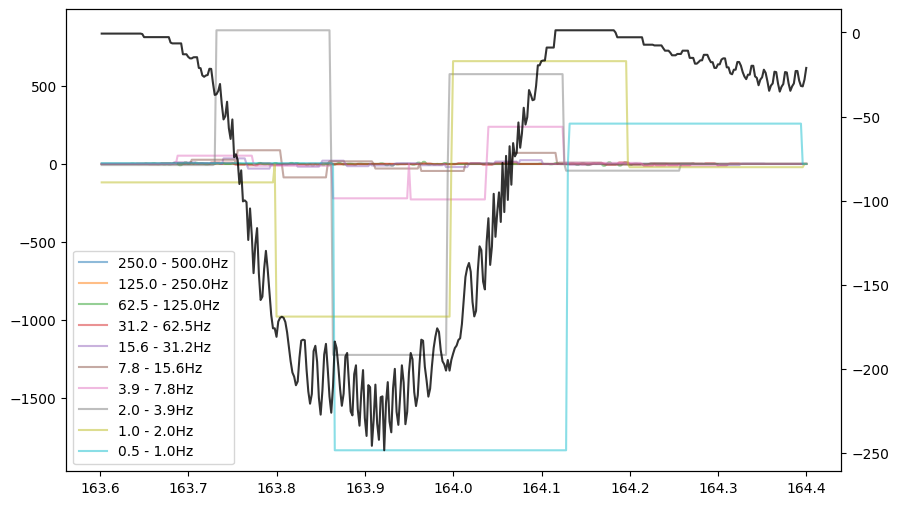

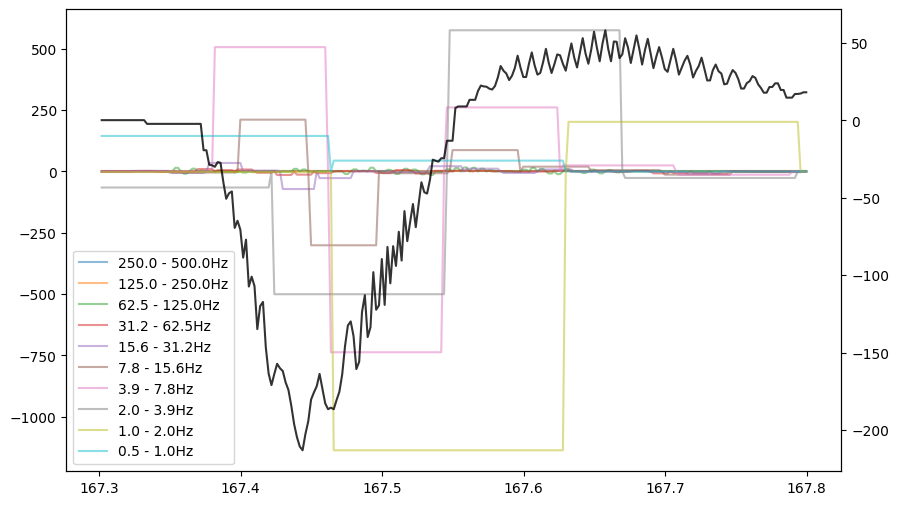

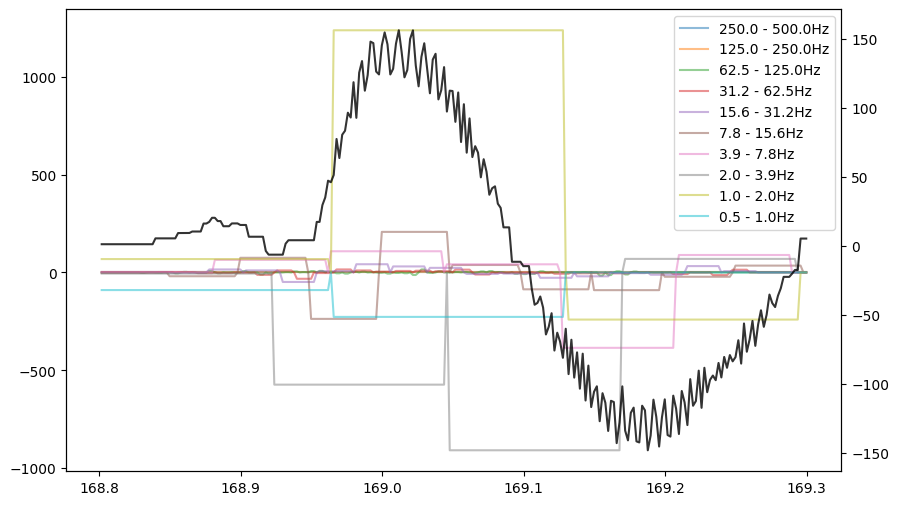

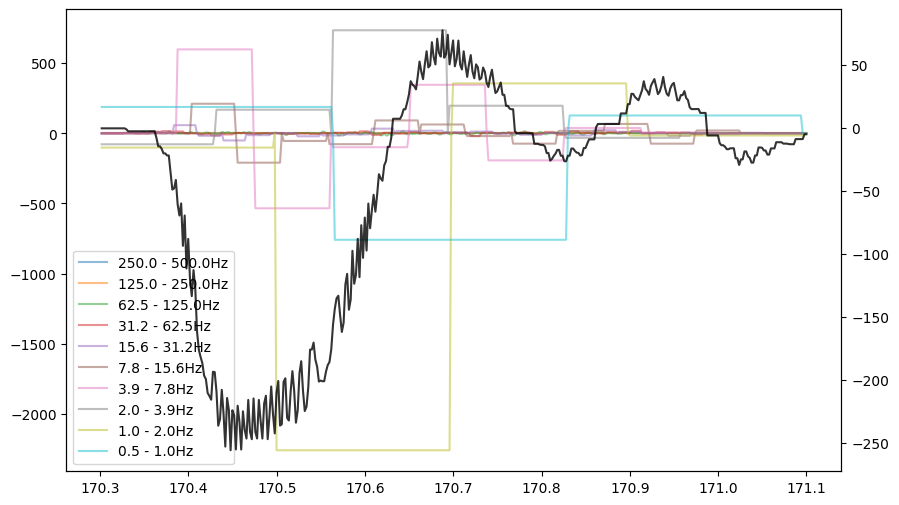

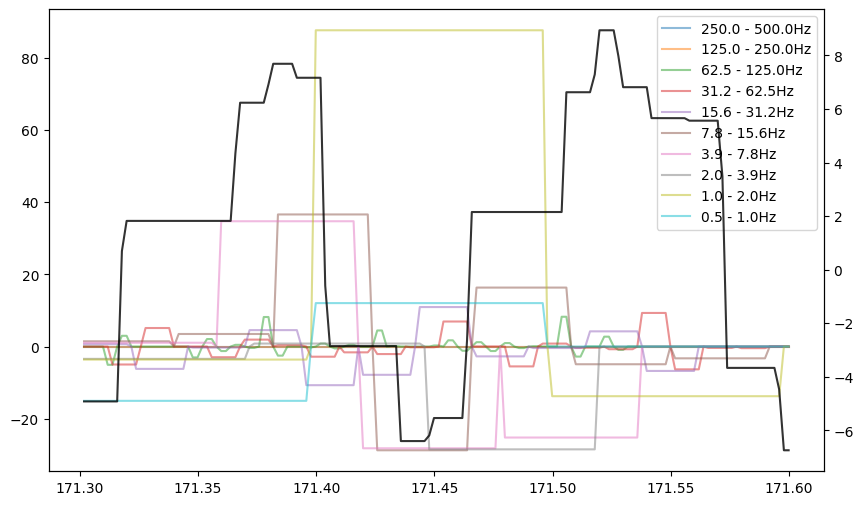

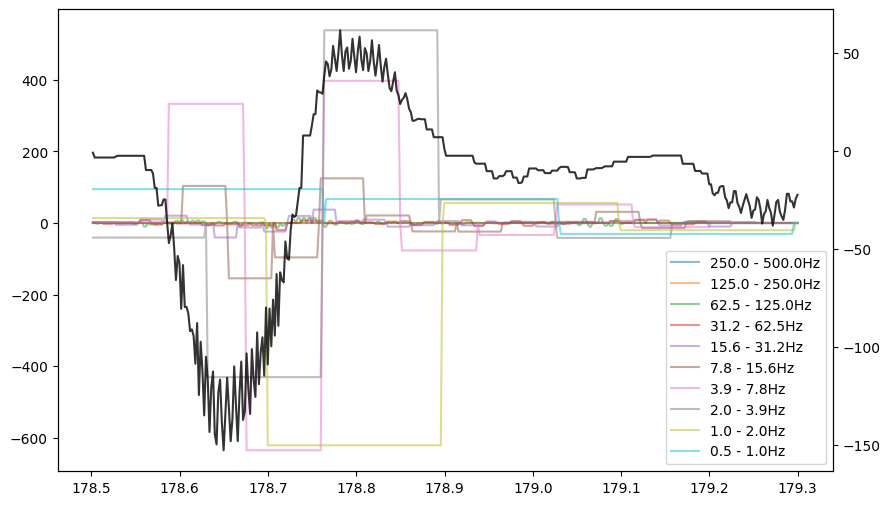

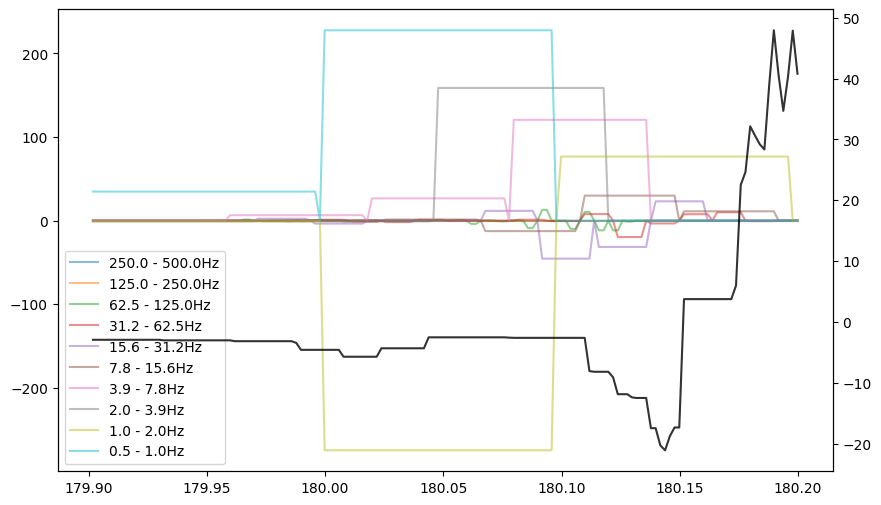

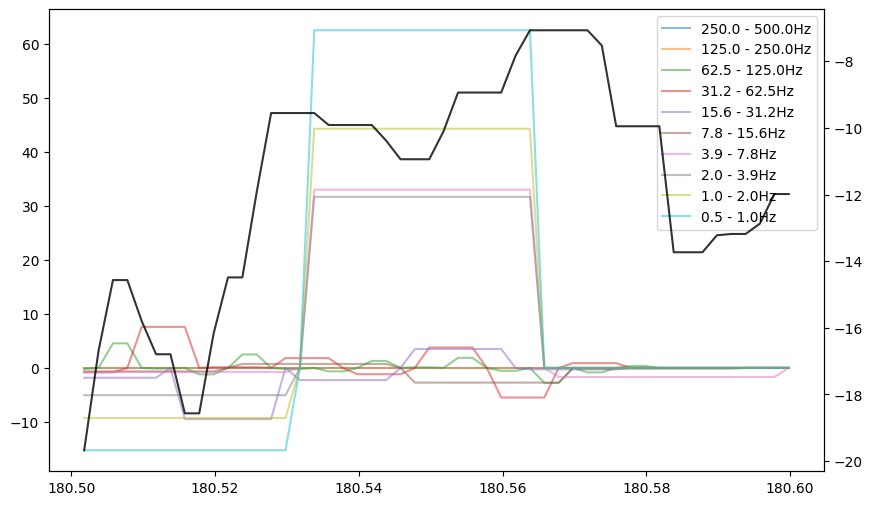

In [18]:

eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids[0:1]):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Find movements
    df = states_trial_type[['Bin', 'trial_id', 'mouse_name', 'session', 'identifiable_states']].copy()
    df = df.loc[(df['session']==eid)].sort_values(by='Bin')
    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1
    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])
    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin']) +1
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])


    # Calculate per movement
    for m, onset in enumerate(movement_onsets[0:10]):
        
        if movement_offsets[m] < onset:
            offset = movement_offsets[m+1]
        else:
            offset = movement_offsets[m]
        if offset - onset > 0.2:
            movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel position']
            movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel times']
            
            time_interval = (offset - onset) * .1 # convert from Bins to seconds
            movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
            movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
            norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

            aligned_array = DWT(movement_velocity)
            lvls = 10
            plot_decomposition(aligned_array[:, 1:], movement_velocity, movement_times[1:], lvls)
            # EMD_plot(movement_velocity, movement_times[1:])


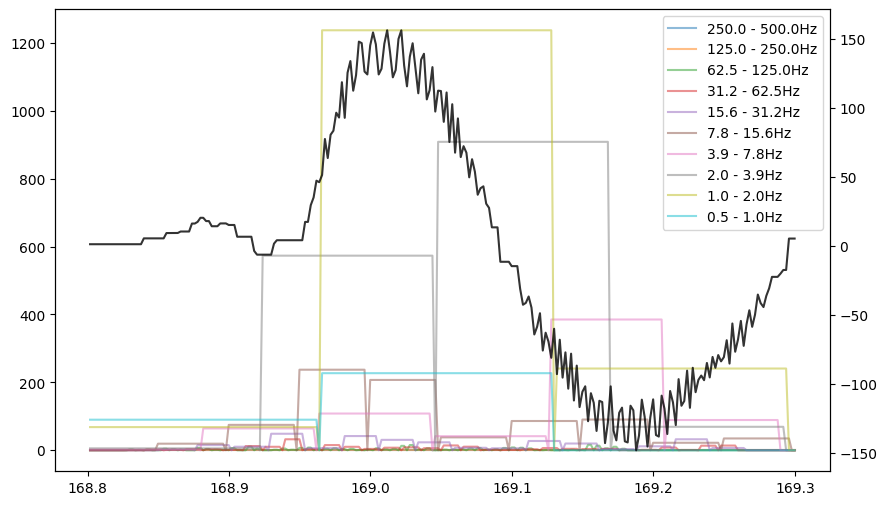

In [36]:
plot_decomposition(np.abs(aligned_array[:, 1:]), movement_velocity, movement_times[1:], lvls)

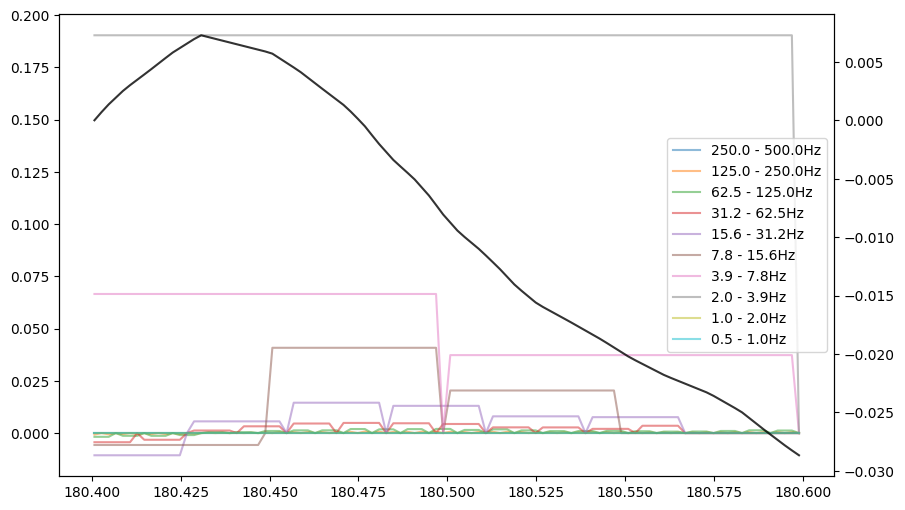

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

for l, level in enumerate(range(lvls)):
    ax1.plot(np.array(movement_times)[::2], aligned_array[level], 
             label=str(str(round(1000/2**(level+2), 1))+' - '+ str(round(1000/2**(level+1), 1)) +'Hz'),
             alpha=0.5)
ax1.legend()
# plt.xlim([00, 5])
ax2.plot(np.array(movement_times)[::2], np.array(data)[::2], color='black', alpha=0.8)
# plt.ylim([-.0025, .0025])
plt.show()


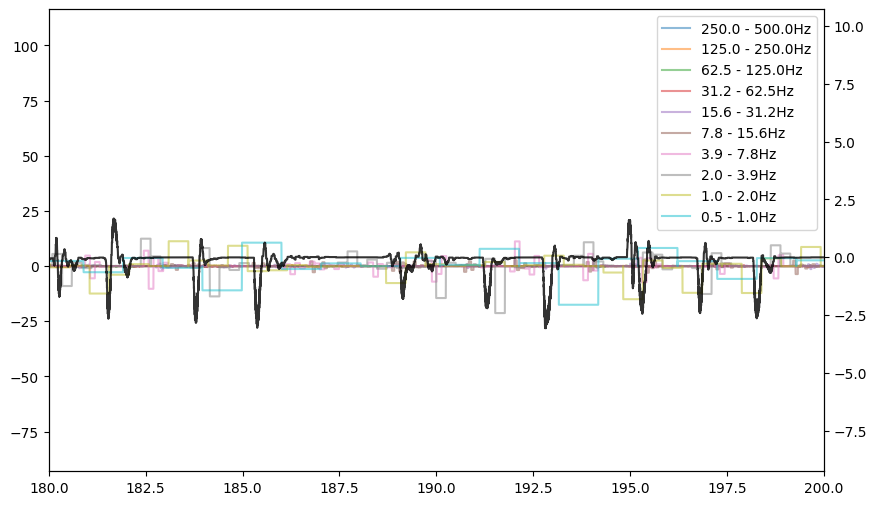

In [30]:

eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids[0:1]):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Plot
    mov_vel = np.diff(pos) /  np.diff(wheel_times)
    aligned_array = DWT(mov_vel)
    data = mov_vel
    lvls = 10
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    for l, level in enumerate(range(lvls)):
        ax1.plot(np.array(wheel_times[1:])[::2], aligned_array[level, 1:], 
                label=str(str(round(1000/2**(level+2), 1))+' - '+ str(round(1000/2**(level+1), 1)) +'Hz'),
                alpha=0.5)
    ax1.legend()
    plt.xlim([180, 200])
    ax2.plot(np.array(wheel_times[1:])[::2], np.array(data)[::2], color='black', alpha=0.8)
    # plt.ylim([-.0025, .0025])
    plt.show()


(100.0, 200.0)

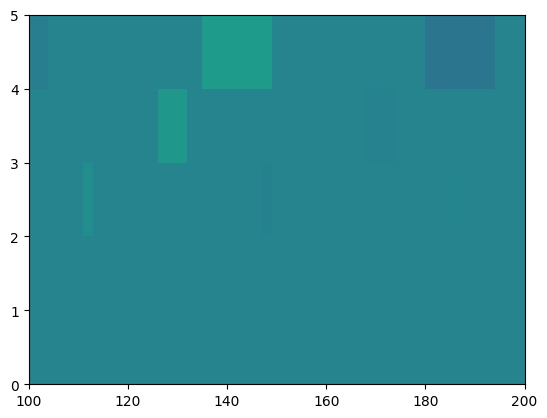

In [16]:
plt.pcolormesh(aligned_array)
plt.xlim([100, 200])

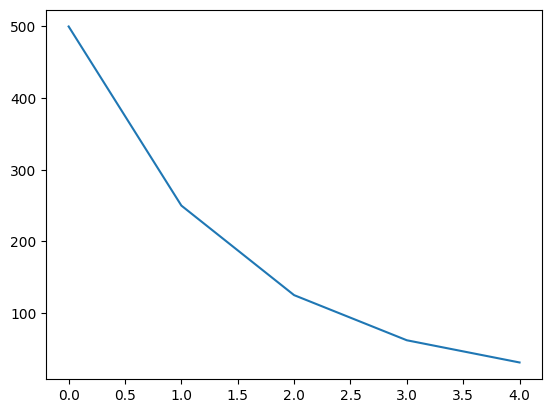

In [39]:
plt.plot([500, 250, 125, 62, 31])

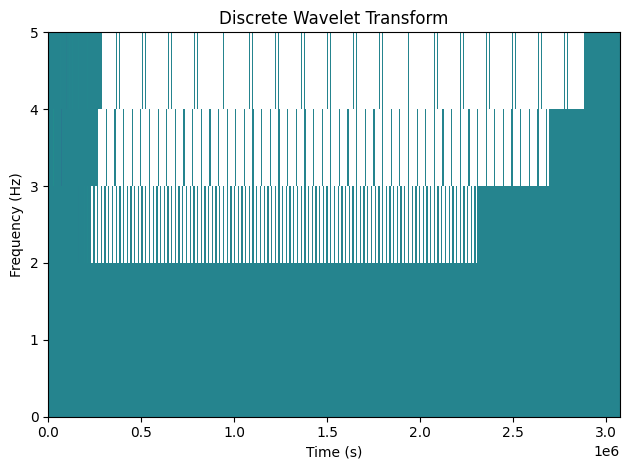

In [9]:
plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Discrete Wavelet Transform')
# X-axis has a linear scale (time)
x = np.linspace(start=0, stop=1, num=N//2)
# Y-axis has a logarithmic scale (frequency)
y = np.logspace(start=lvls-1, stop=0, num=lvls, base=2)
# X, Y = np.meshgrid(x, y)
plt.pcolormesh(aligned_array)

# use_log_scale = False

# if use_log_scale:
#     plt.yscale('log')
# else:
#     yticks = [pow(2, i) for i in range(lvls)]
#     plt.yticks(yticks)

plt.tight_layout()
plt.show()